# Report
---

This report contains description of basic experimental setup with conclusions and proposals for next steps. All experiments included into the repo passed success criteria. 
Main sections: 
   
 **1) Experiment overiew** - Description of method used to train agent.  
 **2) Experiment metadata** - Introduction to experiments metadata and its basic usage.    
 **3) Evaluation of model** - Showcase of model usage   
 **4) Evaluation of results** - Some detailed plots and measurements.   
 **5) Next steps**  

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import logging
import numpy as np
import pickle
import time
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [3]:
import torch
from pddpg_tennis.environment import UnityEnvironmentWrapper
from pddpg_tennis.replay_buffer import ReplayBuffer
from pddpg_tennis.agent import Agent
from pddpg_tennis.training import pddpg_training

In [4]:
def get_avg_scores(scores, n_samples):
    cs = np.cumsum(scores)
    diff = cs[n_samples:] - cs[:-n_samples]
    avg = diff / n_samples
    return avg
    
def get_best_avg_score(scores, n_samples):
    avg = get_avg_scores(scores, n_samples)
    idxs = np.argsort(avg)[::-1][:3]
    avg_subset = avg[idxs]
    
    return idxs + n_samples, avg_subset

def get_occurance(scores, n_samples, value):
    avg = get_avg_scores(scores, n_samples)
    return np.where(avg >= value)[0][0] + n_samples


## Experiment overview

**Intro**   
Main goal in tennis environment is to keep ball in the game as long as possible. So it's cooperative game, where in each state, each agent has it's own state and communicate to environment with it's own set of actions.

To solve tennis environment we used alternative of multiagent actor critic method based on ddpg [[1 Section 4.1]](https://papers.nips.cc/paper/7217-multi-agent-actor-critic-for-mixed-cooperative-competitive-environments.pdf).

**Agent**  
We use one shared critic and 2 actors. Each actor manipulates with one tennis racket. Critic evaluates state of the game based on actions and states of both 2 actors (details how we concatenate states and actions can be found in the code). This leads to rich feedback on real state of the game. On contrary, each actor has it's own set of trainable parameters which are not shared and as input, each actor has it's own state information.

Although that architecture represents one end to end system built of 2 actors and one critic on top, key fact is that we awlays train only one of the actors using single batch while the second actor is fixed. With following batch situation flips. This helps to develop stable diversed strategy fast.

To address exploration-exploitation problem, we generate random noise with Ornstein-Uhlenbeck process which we mix together with actions from actor (original idea was used in Udacity [ddpg bidepadl environmnet task](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal))

**Parameter details**    
Both actor and critic are feed forward neural networks. Actor has 3 layers with relu activations, output has action space size. Critic has also 3 layers of feedforward network, input to 1st layer are concatenated states of both actor state vectors, action vector (created again by concatenation of actions from critics) is concatenated to 2nd layer result.
  
  Params
    * state_size (24): dimension of each state
    * action_size (2): dimension of each action
    * buffer_size (1e6): Replay buffer size
    * batch_size (128): Size of sampled batches from replay buffer
    * lr_actor (1e-4): Learning rate
    * lr_critic (13e-4): Learning rate
    * gamma (0.99): Reward discount
    * tau (1e-2): Soft update of target network parameters


## Experiment metadata

Experiment in repo has it's own metadata file with details of experiemnt and of course separate pytorch weights of trained agent (separatelly for actor and critic). Lets have a look at ```../experiments/basic``` which contains results for basic parallel ddpg setup which we stopped immediately after reaching convergence criteria

In [8]:
meta = pickle.load(open('../experiments/basic/meta.pickle', 'rb'))

In [9]:
# repr string for agent initialization
meta['agent']

'Agent(state_size=24, action_size=2, device="cuda")'

In [12]:
# last 10 result scores during training
meta['scores'][-10:]

[1.4000000208616257,
 0.10000000149011612,
 0.20000000298023224,
 0.70000001043081284,
 1.2000000178813934,
 0.20000000298023224,
 0.5000000074505806,
 1.8000000268220901,
 0.20000000298023224,
 1.3000000193715096]

## Evaluation of model

In [ ]:
env = UnityEnvironmentWrapper(env_binary='../bin/tennis/Tennis.x86_64', train_mode=False)

In [ ]:
agent = Agent(state_size=env.state_size, action_size=env.action_size, device='cuda')

In [ ]:
agent.load('../experiments/basic/model')

In [ ]:
# Evauation of chosen model with reward evolution
states = env.reset()
agent.reset()
score = np.zeros([env.num_agents])
for step in range(1000):
    actions = agent.act(states)
    next_states, rewards, dones = env.step(actions)
    states = next_states
    score += rewards
    time.sleep(0.05)
    if np.any(dones):
        break
print(f'Final score {np.max(score, axis=0)}')

In [ ]:
env.close()

## Evaluation of results
We have run basic mutiagent parallel ddpg setup. Plot you will see represetns progress over binned scores during training. Line represetns gourp of scores in given bin with its variance.

In [13]:
meta_basic = pickle.load(open('../experiments/basic/meta.pickle', 'rb'))
data_basic = pd.DataFrame({'scores': meta_basic['scores'], 'iterations': range(len(meta_basic['scores']))})

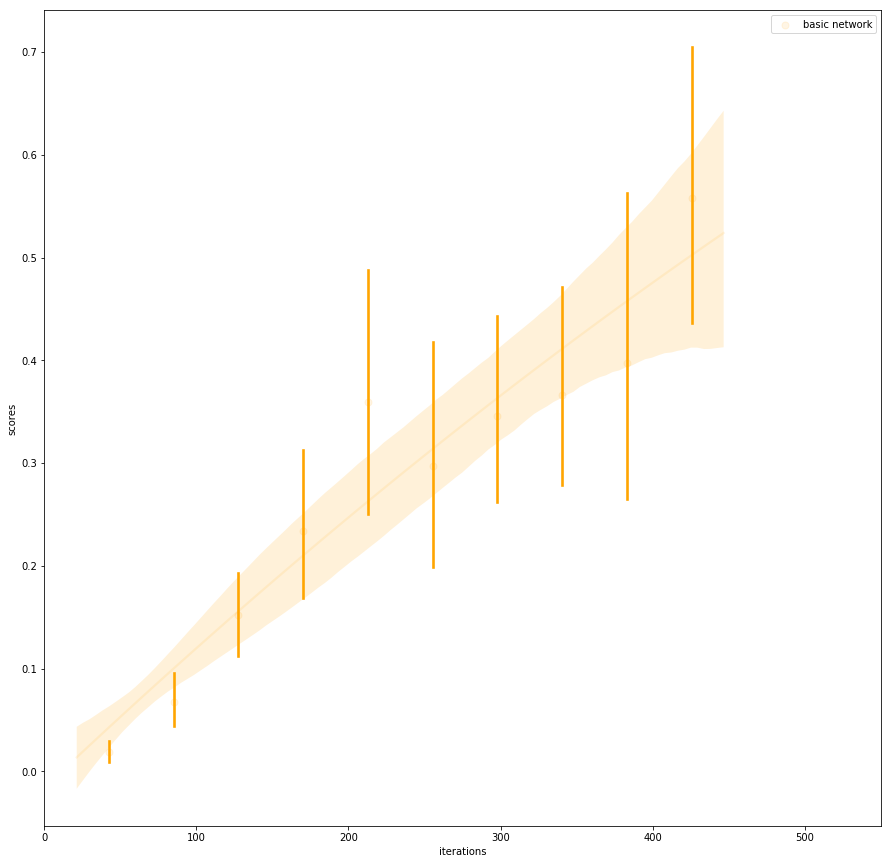

In [16]:
plt.figure(figsize=(15, 15))
ax = plt.gca()
sns.regplot(x='iterations', y='scores', data=data_basic, ax=ax, order=2, x_bins=10, line_kws={'alpha':0.1}, scatter_kws={'alpha':0.1}, color='orange', label='basic network')
plt.xlim(0, 550)
plt.legend()

In [17]:
# iteration when we for the first time reached avg score for 100 consecutive scores >=0.5
get_occurance(meta_basic['scores'], n_samples=100, value=0.5)

468

Text(0.5,0.98,'Plot of raw scores got from each single iteration')

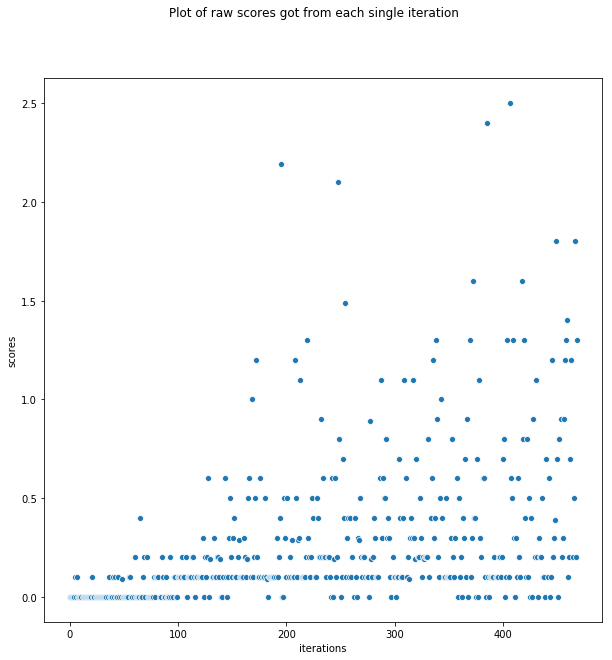

In [18]:
plt.figure(figsize=(10,10))
ax = plt.gca()
sns.scatterplot(x='iterations', y='scores', data=data_basic, ax=ax)
plt.suptitle('Plot of raw scores got from each single iteration')

We can see that we reached avg score 0.5 over 100 consecutive measurements on 468.

## Next steps

 - experiment with architectures of actor and critic
 - tune up all hyperparameters
 - tune up exploration noise